In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import os

modelname="4_30_23_m2"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 512
batch_size = 48
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 14

In [15]:
path_to_data = "data/reddit_scrape_v6.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

92590


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 512])
torch.Size([1, 512, 256])
tensor([[189, 200,   7, 216, 230, 208, 183,   1,  16, 193, 146, 173, 230,   1,
          84, 217, 217,  84, 208,  70,  21, 176, 189, 217, 177, 230,  21, 187,
         230,  16, 216,  16, 183, 157, 217, 189,  16,  16,  27, 230, 208, 200,
         189,  96, 217, 217, 200, 176, 189, 217, 230, 157, 217, 183, 189, 230,
         183,   1, 236, 183, 118,  96, 230,  63,   7, 230,  21,   1, 183, 217,
         217,  83, 208,  70,  70, 176, 189, 146,  21, 200, 236, 230, 183,  21,
         176, 189, 145,  37, 183,  33, 183, 114, 200,  61, 193, 199, 183,  37,
         208,   1, 208, 183, 216, 230, 157,  61, 114, 199, 189,  18, 217, 183,
         200, 199, 199, 189, 216, 176, 217, 189,  37,  37,  37,  59, 176, 157,
          16, 230, 189,  80,  16, 188,  16, 208,  18, 183, 230, 183, 217, 200,
         188,  18, 189, 189, 189,  80, 217, 189,  16, 189,   1,  83, 217,  34,
         176,  18, 217,  16,  56,  16, 230, 118, 230, 148,  16,  61,  80, 230,
     

In [18]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
n_epochs = 40

In [20]:
!nvidia-smi

Sun Apr 30 18:18:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   44C    P0    58W / 150W |   1397MiB / 23028MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(device)

cuda


In [22]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 1929/1929 [27:34<00:00,  1.17it/s]


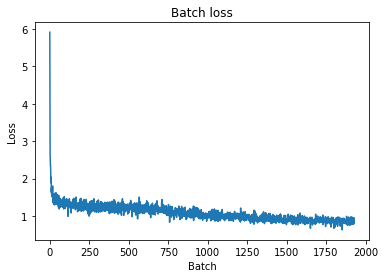

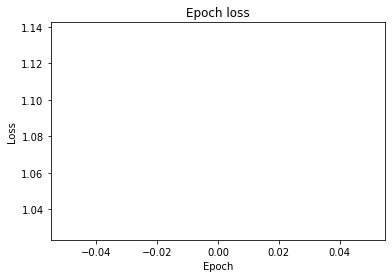

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you would to the are a proges and the son the the sonal the some the some the some the species and the specisifical theread are them are them are them are them are them and the specis and theread and the specis and theread and theread and the specis the specially there are them are them therem and the specically theres and the specicically and the specicial in the specicies and the the specicies intion the the ton the the the the spperice.

Prompt 1: Hello world, 
Model output: Hello world, all all there and and the sone the sone the are problem the solve the specifical the specifical the specical and there are problem the specicaly the specicical and therean and in there and the specis the specically there are them and the specical in the are the are the are the them them and the the specicic in the the specicies intint in the the the the spperic int ton the the the the the the there the the the the

100%|██████████| 1929/1929 [27:29<00:00,  1.17it/s]


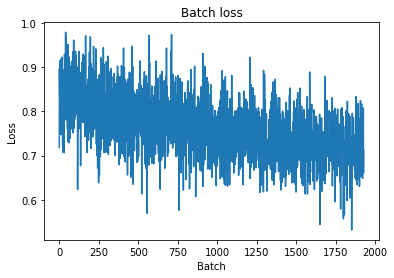

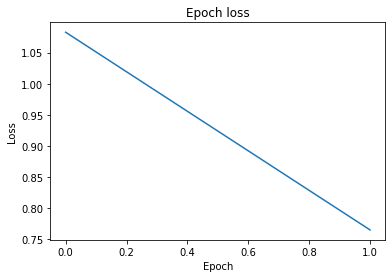

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you aren't all there in there aren't and there there are there are there are there there are there are theres on there therese their to there are theres on there their their thereses to there are their thereses their there are their thereses are thereses there are thereses that there are theres are thereses thereses thereses thereses to there are theres to there their there.

Prompt 1: Hello world, 
Model output: Hello world, there array there array there array there array therary for therapy. 
Is think there are there are there are there are theres are there are theres on there thereses toricles there are there their thereses to are there are theres are thereses there are thereses thereseseres thereses thereseses thereseses thereses are thereses thereses are thereses are theres are theres on there there.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
If you are there are you could 

  9%|▉         | 175/1929 [02:29<25:09,  1.16it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1929/1929 [27:30<00:00,  1.17it/s]


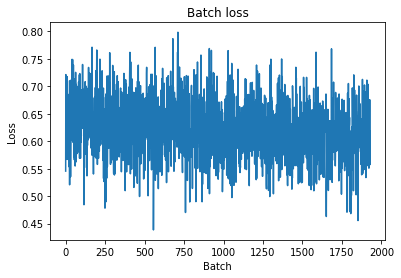

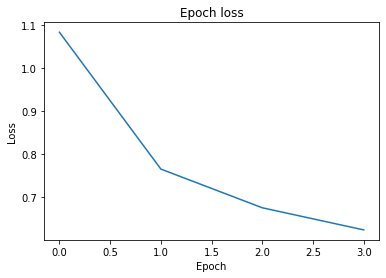

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you want to use the state there aren't as a lot of the steps of there aren's and there are there are there aren's not there aren's there aren't should benefit there. If you want to shore there are there aren't always there are there aren't so there are there. If you're there are there are there aren't there aren't there are there.

Prompt 1: Hello world, 
Model output: Hello world, tunes in a senior there. What would be any?
I would start the steps that is there aren't a steper that there are there aren's a steper that there are there aren's a probably there are there. I would like there are there aren's a little there aren't there aren't there are there. I wn there are there aren's there are there aren's there aren't there aren't there aren't there are there.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
If youre code there are there are there are there aren't always there are the

100%|██████████| 1929/1929 [27:29<00:00,  1.17it/s]


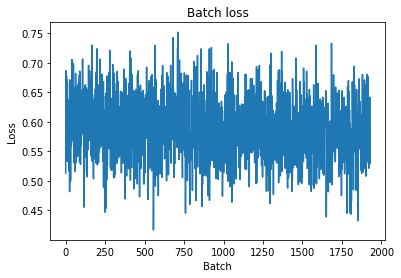

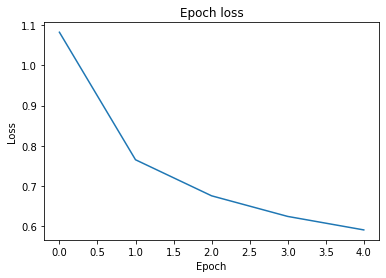

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you have a look at the stem line in the stem there aren's a little that there is a little that is a little that issue. If you want there are a little that issue is there are all the steps there are there are non there are there. I have there are there are there are there are there are there are there. I had there are there are there are there are there.

Prompt 1: Hello world, 
Model output: Hello world, should I hope them I hoper them them in there?
I have a senior that in there is a single that is there any there is a single that there is a single that is there aren's a single the same thing that is a single there aren's assusted there. I wn there is a single there are there are there are there are there. I wn there is a single there any there is a single there any there.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
I used this in the state there are there are normal there. I ha

100%|██████████| 1929/1929 [27:28<00:00,  1.17it/s]


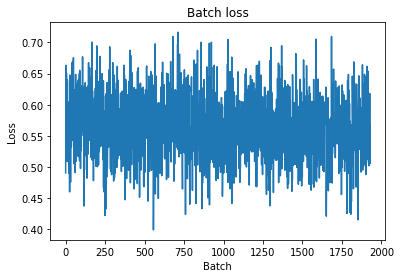

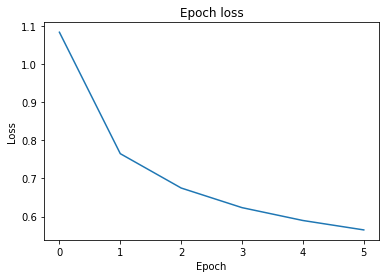

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I have a senior that is the same theory as theory as a significant that is a single theorem and the same theory of their size of the size of the side and the same theory theory theories is there are their steps their and their stering their control their theories their consense.

Prompt 1: Hello world, 
Model output: Hello world, should I use it in a pring and should I have a senior in the sensor to the sensor the sense of the stem in the sensor term of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the stem of the sterm in the section of the interned to the send the sterm of the intered to the server in the server in the server the industred.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
I use the string in the sem to the sensor the string the sensor the string the sensor the string the s

100%|██████████| 1929/1929 [27:29<00:00,  1.17it/s]


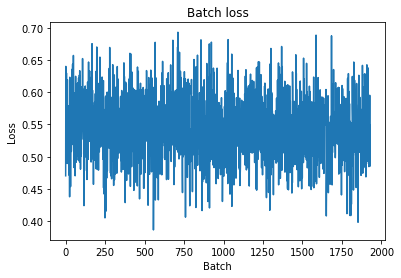

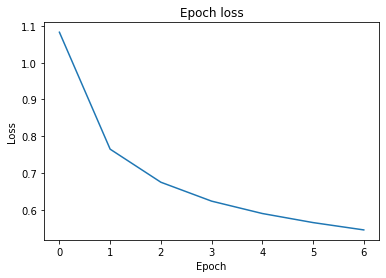

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I have a sen the stem the same the stem of the stem the same theory and the step theory their is a step theory theory thing their steps their problem. I would the same time theory theory is the same theory theory theory theory theory theory theory theory theory theory theory theories in the second theorems are their stering their problems.

Prompt 1: Hello world, 
Model output: Hello world, what would bring the stem of the stem of the stem of the stem of the stem of the stem to their intention their intenses?
I think you can the step the sensor there is a stem there is a stem there in the sementer there. I would stay the same there is a stem there in the same time there is a stem there is a stem there is a stem there is a stem there is a stem there is a stem the same time there.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
I always used the string the string the string the string the

100%|██████████| 1929/1929 [27:24<00:00,  1.17it/s]


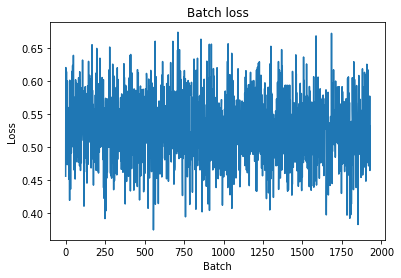

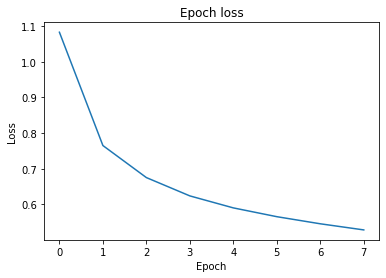

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I have a state of the state of the state of the state of the state of the state of the state of the state of the state of the state of the state there.                                                                                                                                                                                                                                                                                                                                                                                                                           

Prompt 1: Hello world, 
Model output: Hello world, i wory follow the study of situations from a condition and site contract the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of the site of 

100%|██████████| 1929/1929 [27:28<00:00,  1.17it/s]


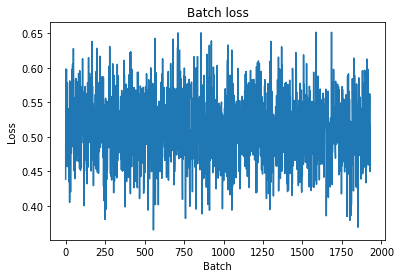

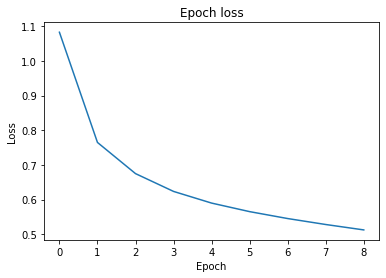

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I have a statistical statistical statistical statistical statistical statistical statistical statistical and statistical statistical statistical statistical statistical and statistical statistical statistical statistical statistical statistical statistical statistical statistical statistical and statistical statistical statistical statistical statistical statistical statistical statistical statistical statistical and statistical statistical statical statical statistical statistical statisticalaged.

Prompt 1: Hello world, 
Model output: Hello world, what would briefly for?
I would like the steps and the step the step the step theory theory theory theory that they would be a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a steper that there is a ste

In [ ]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()